In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

In [3]:
# Step 1: Load Data
df = pd.read_csv('mcdonalds.csv')

In [4]:
# Step 2: Explore Data
print(df.shape)
print(df.columns)
print(df.head(3))

(1453, 15)
Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [5]:
# Step 3: Convert YES/NO to binary for segmentation variables (first 11 columns)
segmentation_cols = df.columns[:11]
MD_x = df[segmentation_cols].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
print(MD_x.head(3))
print(np.round(MD_x.mean(), 2))

   yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  expensive  \
0      0           1      0          1       0     1      1      0          1   
1      1           1      0          1       1     1      1      1          1   
2      0           1      1          1       1     1      0      1          1   

   healthy  disgusting  
0        0           0  
1        0           0  
2        1           0  
yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


C:\Users\apoor\AppData\Local\Temp\ipykernel_24844\1613941143.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = df[segmentation_cols].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)


In [6]:
# Step 4: Principal Component Analysis (PCA)
pca = PCA()
MD_x_pca = pca.fit_transform(MD_x)
explained_var = np.cumsum(pca.explained_variance_ratio_)
print('Explained variance by components:', explained_var)

Explained variance by components: [0.29944723 0.49224445 0.6252898  0.70838558 0.7678661  0.81816566
 0.86201476 0.90156255 0.93832345 0.97067674 1.        ]


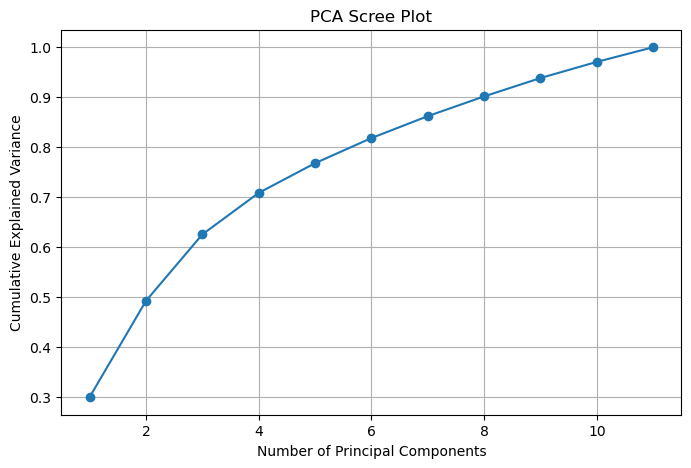

In [7]:
# Scree plot for PCA
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.show()


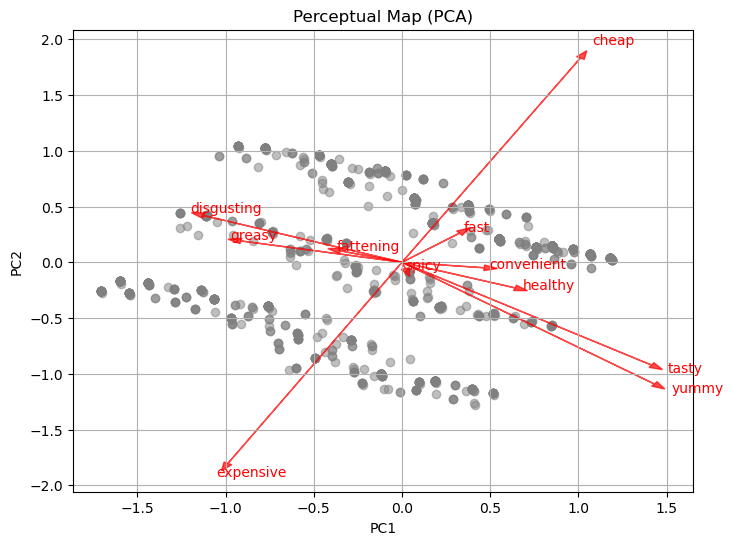

In [8]:
# Perceptual Map (first two principal components)
plt.figure(figsize=(8,6))
plt.scatter(MD_x_pca[:,0], MD_x_pca[:,1], alpha=0.5, color='grey')
# Add arrows for original variables
for i, col in enumerate(segmentation_cols):
    plt.arrow(0, 0, pca.components_[0,i]*3, pca.components_[1,i]*3, 
              color='r', alpha=0.7, head_width=0.05)
    plt.text(pca.components_[0,i]*3.2, pca.components_[1,i]*3.2, col, color='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Perceptual Map (PCA)')
plt.grid(True)
plt.show()


In [9]:
# Step 5: K-Means Clustering for 2 to 8 segments
inertia = []
kmeans_models = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    inertia.append(kmeans.inertia_)
    kmeans_models[k] = kmeans


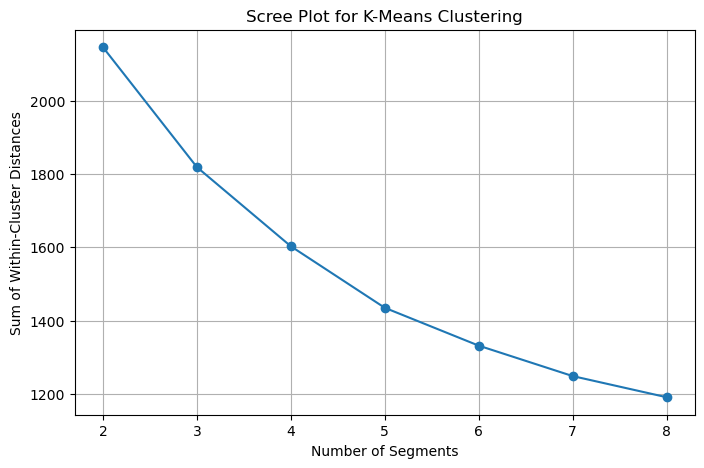

In [10]:
# Scree plot for K-Means
plt.figure(figsize=(8,5))
plt.plot(range(2,9), inertia, marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Sum of Within-Cluster Distances')
plt.title('Scree Plot for K-Means Clustering')
plt.grid(True)
plt.show()

In [11]:
# Step 6: Cluster Stability Analysis (Bootstrap, Adjusted Rand Index)
def cluster_stability(X, k, n_boot=100, n_init=10, random_state=1234):
    np.random.seed(random_state)
    base_kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    base_labels = base_kmeans.fit_predict(X)
    ari_scores = []
    for _ in range(n_boot):
        X_boot = resample(X, replace=True, random_state=np.random.randint(0, 10000))
        boot_kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        boot_labels = boot_kmeans.fit_predict(X_boot)
        # Map boot_labels to base_labels using the original samples' indices
        # For ARI, need to compare clustering on same samples, so use intersection
        idx = np.intersect1d(X.index, X_boot.index)
        if len(idx) > 0:
            ari = adjusted_rand_score(base_labels[idx], boot_labels[:len(idx)])
            ari_scores.append(ari)
    return ari_scores

stability_results = {}
for k in range(2, 9):
    ari_scores = cluster_stability(MD_x, k)
    stability_results[k] = ari_scores


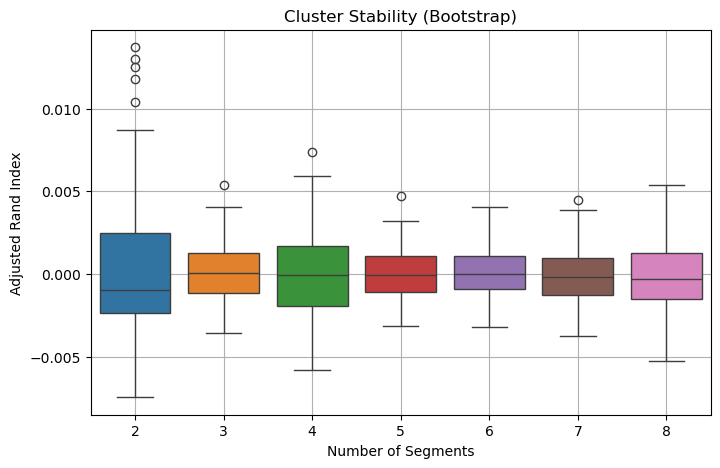

In [12]:
# Boxplot of stability
plt.figure(figsize=(8,5))
sns.boxplot(data=[stability_results[k] for k in range(2,9)])
plt.xticks(ticks=range(0,7), labels=range(2,9))
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Cluster Stability (Bootstrap)')
plt.grid(True)
plt.show()

In [18]:
from prince import FAMD

# Check the shape of the dataframe and ensure all columns have the same number of rows
print("DataFrame Shape:", df.shape)

# Clean 'Like' column to ensure it has only numeric values (after removing non-numeric parts)
df['Like'] = df['Like'].astype(str)  # Convert to string type
df['Like'] = df['Like'].str.extract('(\d+)')  # Extract numeric part only
df['Like'] = pd.to_numeric(df['Like'], errors='coerce').fillna(0).astype(int)  # Convert to int after cleaning

# Map 'VisitFrequency' to numeric values
df['VisitFrequency'] = df['VisitFrequency'].map({
    'Never': 0,
    'Once a year': 1,
    'Every three months': 2,
    'Once a month': 3,
    'Once a week': 4,
    'More than once a week': 5
}).fillna(0)

# Ensure 'Age' is numeric and fill NaN values with the median
df['Age'] = pd.to_numeric(df['Age'], errors='coerce').fillna(df['Age'].median())

# Check the segmentation columns to make sure they align with the DataFrame's structure
segmentation_cols = df.columns[:11]  # Adjust this based on your dataset
print("Segmentation Columns:", segmentation_cols)

# Check the shape of the columns you are passing to FAMD
famd_input_columns = segmentation_cols.tolist() + ['Like', 'VisitFrequency', 'Age']
print("FAMD Input Columns:", famd_input_columns)

# Ensure the FAMD input has no missing values (NaN values) before passing to the model
if df[famd_input_columns].isnull().any().any():
    print("Warning: There are missing values in the input columns. Filling missing values with 0.")
    df[famd_input_columns] = df[famd_input_columns].fillna(0)

# Perform FAMD on the relevant columns
famd = FAMD(n_components=2, random_state=1234)
famd_fit = famd.fit(df[famd_input_columns])

# Optionally, print results or use the fitted model (e.g., for visualization or analysis)
print(famd_fit)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\apoor\AppData\Local\Temp\ipykernel_24844\2918270238.py:8: SyntaxWarning: invalid escape sequence '\d'
  df['Like'] = df['Like'].str.extract('(\d+)')  # Extract numeric part only


DataFrame Shape: (1453, 15)
Segmentation Columns: Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting'],
      dtype='object')
FAMD Input Columns: ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'VisitFrequency', 'Age']
FAMD(random_state=1234)


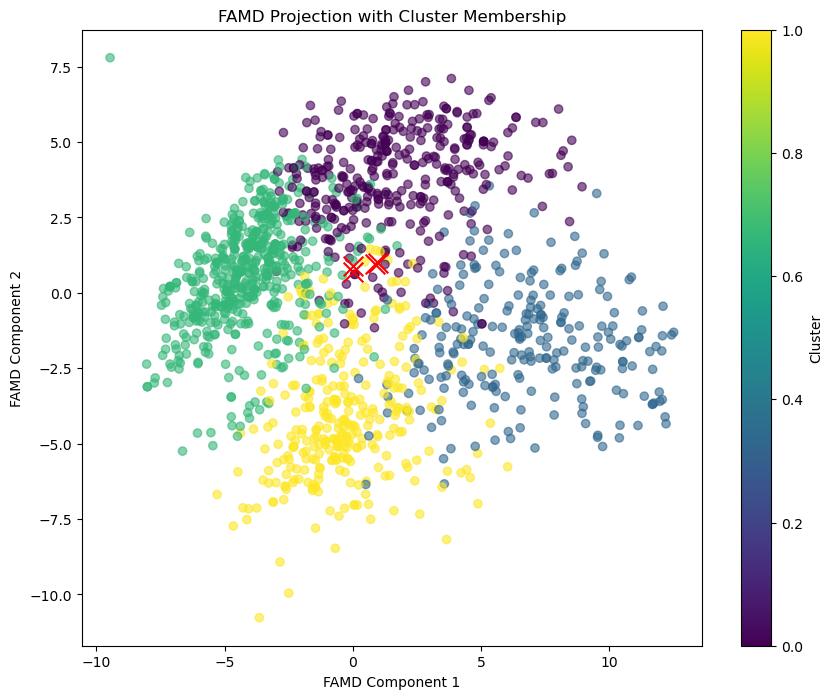

In [21]:
# List of columns used in segmentation and additional columns
segmentation_cols = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 
                     'tasty', 'expensive', 'healthy', 'disgusting']
additional_cols = ['Like', 'VisitFrequency', 'Age']

# Ensure columns are present
columns_to_use = segmentation_cols + additional_cols

# Get the row coordinates (factor scores) from the FAMD model
famd_coordinates = famd.row_coordinates(df[columns_to_use])

# Plot FAMD results
plt.figure(figsize=(10, 8))

# Plot the FAMD projections (row coordinates)
plt.scatter(famd_coordinates[0], famd_coordinates[1], alpha=0.6, c=kmeans_models[4].labels_, cmap='viridis')

# Optionally, add cluster centroids to the plot
centroids = kmeans_models[4].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, color='red', label='Centroids')

# Add labels and title
plt.title('FAMD Projection with Cluster Membership')
plt.xlabel('FAMD Component 1')
plt.ylabel('FAMD Component 2')

# Add color bar for cluster labels
plt.colorbar(label='Cluster')

# Show plot
plt.show()

In [22]:
# Step 8: Mixture Models
from sklearn.mixture import BayesianGaussianMixture

# Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(n_components=4, 
                               random_state=1234,
                               max_iter=1000)
bgmm_labels = bgmm.fit_predict(MD_x)

# Compare with k-means clustering
print("ARI between K-Means and BGMM:", 
      adjusted_rand_score(kmeans_models[4].labels_, bgmm_labels))

ARI between K-Means and BGMM: 0.6084286001484009


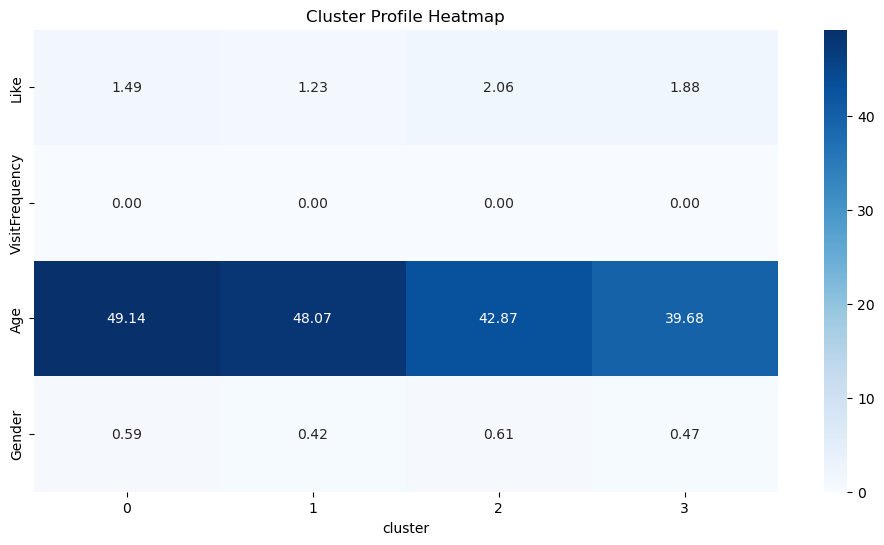

In [24]:
# Step 9: Cluster Profiling
# Create a new column for cluster labels
df['cluster'] = kmeans_models[4].labels_

# Aggregate data for each cluster
cluster_profile = df.groupby('cluster').agg({
    'Like': 'mean',
    'VisitFrequency': 'mean',
    'Age': 'mean',
    'Gender': lambda x: x.value_counts(normalize=True).get('Female', 0)
}).reset_index()

# Visualize cluster profiles using a heatmap
plt.figure(figsize=(12,6))
sns.heatmap(cluster_profile.set_index('cluster').T, 
            annot=True, cmap='Blues', fmt=".2f")
plt.title('Cluster Profile Heatmap')
plt.show()

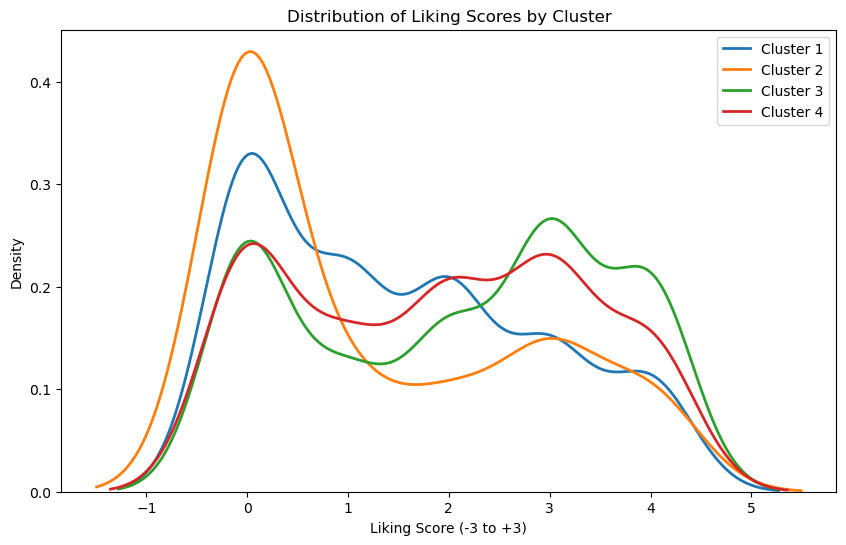

In [25]:
# Step 10: Target Segment Selection
# Plot 'Like' distribution across clusters
plt.figure(figsize=(10,6))
for cluster in sorted(df['cluster'].unique()):
    sns.kdeplot(df[df['cluster'] == cluster]['Like'], 
                label=f'Cluster {cluster+1}', linewidth=2)
plt.title('Distribution of Liking Scores by Cluster')
plt.xlabel('Liking Score (-3 to +3)')
plt.ylabel('Density')
plt.legend()
plt.show()


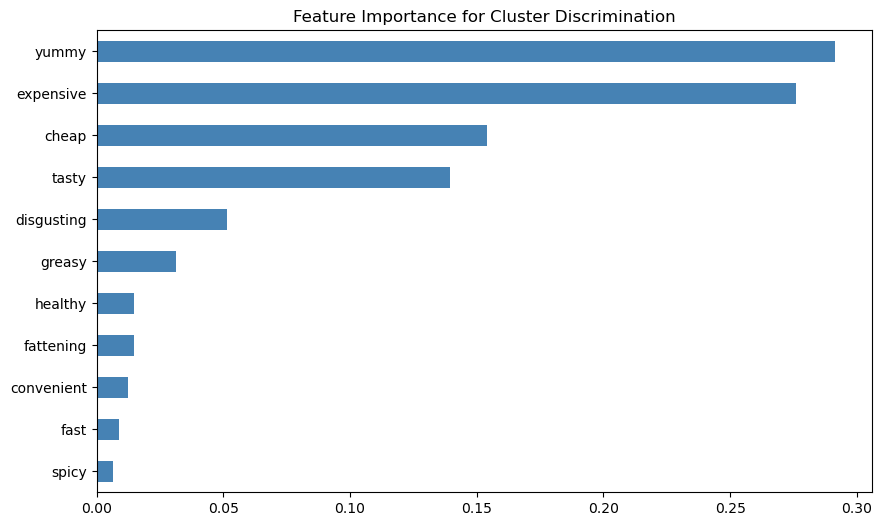

In [26]:
# Step 11: Customizing Marketing Mix
# Calculate variable importance for each cluster
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=1234)
clf.fit(MD_x, kmeans_models[4].labels_)

# Plot feature importance
plt.figure(figsize=(10,6))
pd.Series(clf.feature_importances_, index=segmentation_cols)\
  .sort_values()\
  .plot(kind='barh', color='steelblue')
plt.title('Feature Importance for Cluster Discrimination')
plt.show()